In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
# !pip install plotly

# Task1: Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

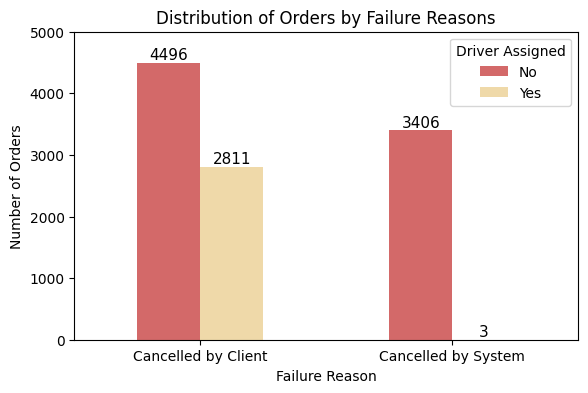

The category with the highest number of orders is 'Cancelled by Client (Before Driver Assignment)' with 4496 orders.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
# import os
# print(os.getcwd())
data_orders = pd.read_csv("datasets/data_orders.csv")
# print(data_orders.loc[(data_orders['order_status_key']==9)&(data_orders['is_driver_assigned_key']==1)])

def categorize_failure_reason(row):
    if row['order_status_key'] == 4:
         return 'Cancelled by Client'
    elif row['order_status_key'] == 9:
        return 'Cancelled by System'
    else:
        return 'Successful'
data_orders['failure_reason'] = data_orders.apply(categorize_failure_reason, axis=1)

plt.figure(figsize=(6.5, 4))
ax=sns.countplot(x='failure_reason', hue='is_driver_assigned_key', data=data_orders, order=['Cancelled by Client','Cancelled by System']
                 ,palette=['#e55757','#fbdd9d'],width=0.5)

for i, p in enumerate(ax.patches[:4]):  
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()), ha='center', va='bottom', fontsize=11)
plt.title('Distribution of Orders by Failure Reasons')
plt.xlabel('Failure Reason')
plt.ylabel('Number of Orders')
plt.ylim(0,5000)
plt.legend(title='Driver Assigned', loc='upper right', labels=['No', 'Yes'])
plt.show()

def detailed_failure_reason(row):
    if row['order_status_key'] == 4:
        if row['is_driver_assigned_key'] == 0:
            return 'Cancelled by Client (Before Driver Assignment)'
        else:
            return 'Cancelled by Client (After Driver Assignment)'
    elif row['order_status_key'] == 9:
        if row['is_driver_assigned_key'] == 0:
            return 'Cancelled by System (Before Driver Assignment)'
        else:
            return 'Cancelled by System (After Driver Assignment)'
    else:
        return 'Successful'
data_orders['detailed_failure_reason'] = data_orders.apply(detailed_failure_reason, axis=1)

max_failure_category = data_orders['detailed_failure_reason'].value_counts().idxmax()
max_failure_count = data_orders['detailed_failure_reason'].value_counts().max()
print(f"The category with the highest number of orders is '{max_failure_category}' with {max_failure_count} orders.")

# Task2: Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [4]:
print(type(data_orders['order_datetime'][0]))

<class 'str'>


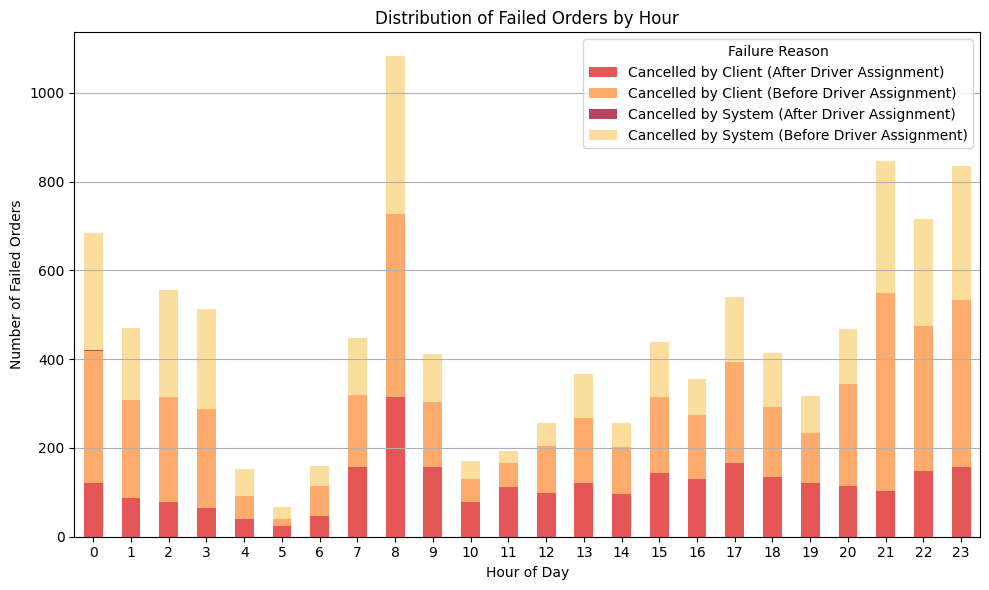

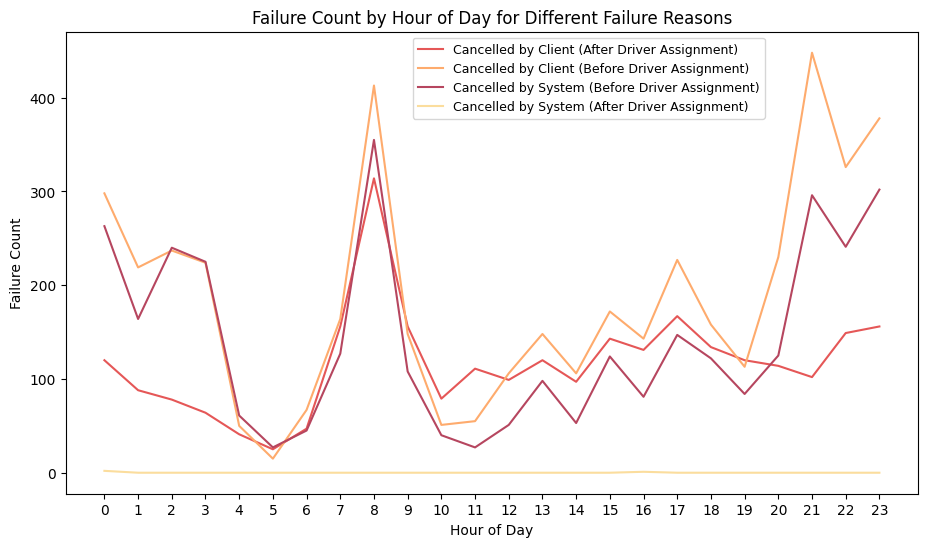

In [28]:
# Convert the order_datetime column to datetime format
data_orders['order_datetime'] = pd.to_datetime(data_orders['order_datetime'])
# Extract the hour component from the order_datetime column
data_orders['hour'] = data_orders['order_datetime'].dt.hour
# data_orders['hour']

failure_counts = data_orders.groupby(['hour', 'detailed_failure_reason']).size().unstack(fill_value=0)
colors = {
    'Cancelled by Client (After Driver Assignment)': '#e55757',
    'Cancelled by Client (Before Driver Assignment)': '#feab6d',
    'Cancelled by System (After Driver Assignment)': '#B6465F',
    'Cancelled by System (Before Driver Assignment)': '#fbdd9d'
}
color_list = [colors[reason] for reason in failure_counts.columns]

failure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_list)
plt.title('Distribution of Failed Orders by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Failed Orders')
plt.legend(title='Failure Reason')
plt.xticks(range(24), rotation=0) 
plt.grid(axis='y')
plt.tight_layout() 
plt.show()

# sns.despine()
all_hours_index = pd.MultiIndex.from_product([data_orders['detailed_failure_reason'].unique(), range(24)], names=['detailed_failure_reason', 'hour'])
failure_counts = data_orders.groupby(['detailed_failure_reason', 'hour']).size().reindex(all_hours_index, fill_value=0)
failure_counts = failure_counts.reset_index(name='failure_count')
failure_counts
plt.figure(figsize=(11,6))
sns.lineplot(data=failure_counts,x='hour',y='failure_count',hue='detailed_failure_reason',palette=color_list)   
plt.xlabel('Hour of Day')
plt.ylabel('Failure Count')
plt.title('Failure Count by Hour of Day for Different Failure Reasons')
plt.legend(bbox_to_anchor=(0.4,1),prop = {'size':9})
hour_ticks = range(24)
plt.xticks(hour_ticks)
plt.show()
# failure_counts

# Task3: Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [7]:
data_orders.columns

Index(['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta',
       'order_gk', 'order_status_key', 'is_driver_assigned_key',
       'cancellations_time_in_seconds', 'failure_reason',
       'detailed_failure_reason', 'hour'],
      dtype='object')

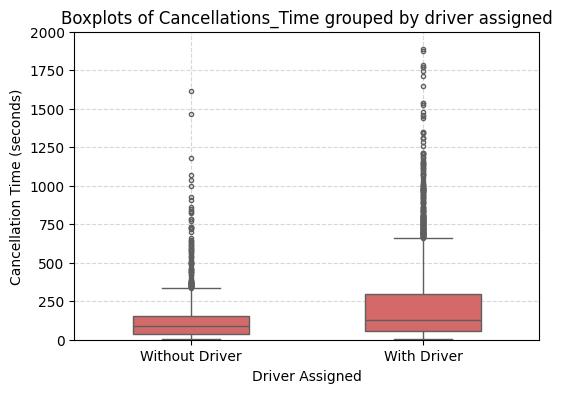

In [8]:
fig, axes = plt.subplots(figsize=(6, 4))
sns.boxplot(x='is_driver_assigned_key', y='cancellations_time_in_seconds',
            data=data_orders, orient='v', ax=axes, fliersize=3,color='#e55757',width=0.5,
            flierprops={'marker': 'o', 'color': 'black'})

axes.set_title('Boxplots of Cancellations_Time grouped by driver assigned')
axes.set_xlabel('Driver Assigned')
axes.set_ylabel('Cancellation Time (seconds)')
axes.set_xticks([0, 1])
axes.set_xticklabels(['Without Driver', 'With Driver'])
axes.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0,2000)
plt.show()

In [9]:
avg_time = data_orders.groupby(['hour','is_driver_assigned_key'],as_index=False).agg({'cancellations_time_in_seconds': 'mean'})
avg_time.head(5)
# data_orders.groupby(['hour','is_driver_assigned_key'],as_index=False)['cancellations_time_in_seconds']

,hour,is_driver_assigned_key,cancellations_time_in_seconds
0,0,0,111.557047
1,0,1,293.616667
2,1,0,98.132420
3,1,1,247.715909
4,2,0,106.438819


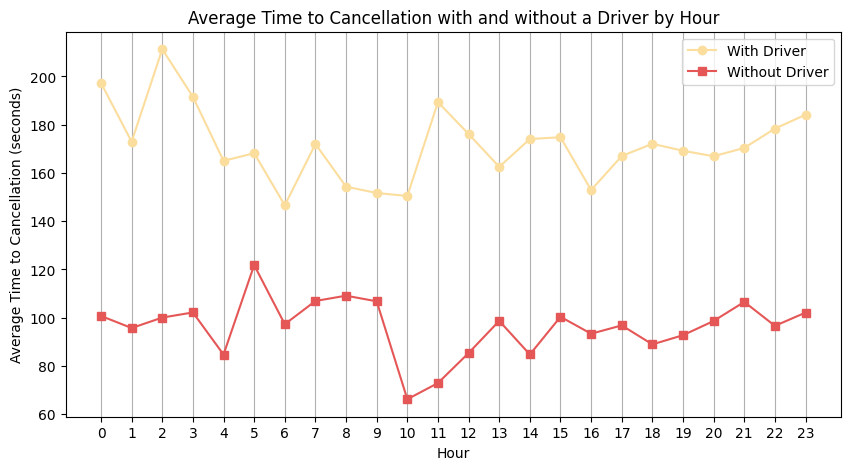

In [10]:
# Remove outliers from cancellation_time_in_seconds column
q1_withDriver = data_orders[data_orders['is_driver_assigned_key'] == 1]['cancellations_time_in_seconds'].quantile(0.25)
# print(q1_withDriver)
q3_withDriver = data_orders[data_orders['is_driver_assigned_key'] == 1]['cancellations_time_in_seconds'].quantile(0.75)
# print(q3_withDriver)
q1_withoutDriver = data_orders[data_orders['is_driver_assigned_key'] == 0]['cancellations_time_in_seconds'].quantile(0.25)
# print(q1_withoutDriver)
q3_withoutDriver = data_orders[data_orders['is_driver_assigned_key'] == 0]['cancellations_time_in_seconds'].quantile(0.75)
# print(q3_withoutDriver)
iqr_withDriver = q3_withDriver - q1_withDriver
lower_bound_withDriver = q1_withDriver - 1.5 * iqr_withDriver
upper_bound_withDriver = q3_withDriver + 1.5 * iqr_withDriver
iqr_withoutDriver = q3_withoutDriver - q1_withoutDriver
lower_bound_withoutDriver = q1_withoutDriver - 1.5 * iqr_withoutDriver
upper_bound_withoutDriver = q3_withoutDriver + 1.5 * iqr_withoutDriver
data_withDriver_clean = data_orders[(data_orders['is_driver_assigned_key'] == 1) & 
                                   (data_orders['cancellations_time_in_seconds'] >= lower_bound_withDriver) &
                                   (data_orders['cancellations_time_in_seconds'] <= upper_bound_withDriver)]
data_withoutDriver_clean = data_orders[(data_orders['is_driver_assigned_key'] == 0) & 
                                      (data_orders['cancellations_time_in_seconds'] >= lower_bound_withoutDriver) &
                                      (data_orders['cancellations_time_in_seconds'] <= upper_bound_withoutDriver)]
# Calculate the average time to cancellation with and without a driver, by the hour
average_cancellation_time_with_driver = data_withDriver_clean.groupby('hour')['cancellations_time_in_seconds'].mean()
average_cancellation_time_without_driver = data_withoutDriver_clean.groupby('hour')['cancellations_time_in_seconds'].mean()
plt.figure(figsize=(10,5))
# ['#e55757','#fbdd9d']
plt.plot(average_cancellation_time_with_driver.index, average_cancellation_time_with_driver, marker='o',label='With Driver',color='#fbdd9d')
plt.plot(average_cancellation_time_without_driver.index, average_cancellation_time_without_driver, marker='s',label='Without Driver',color='#e55757')
plt.xlabel('Hour')
plt.ylabel('Average Time to Cancellation (seconds)')
plt.title('Average Time to Cancellation with and without a Driver by Hour')
plt.xticks(range(24), rotation=0) 
plt.legend()
plt.grid(axis='x')
plt.show()

# Task4: Plot the distribution of average ETA by hours. How can this plot be explained?

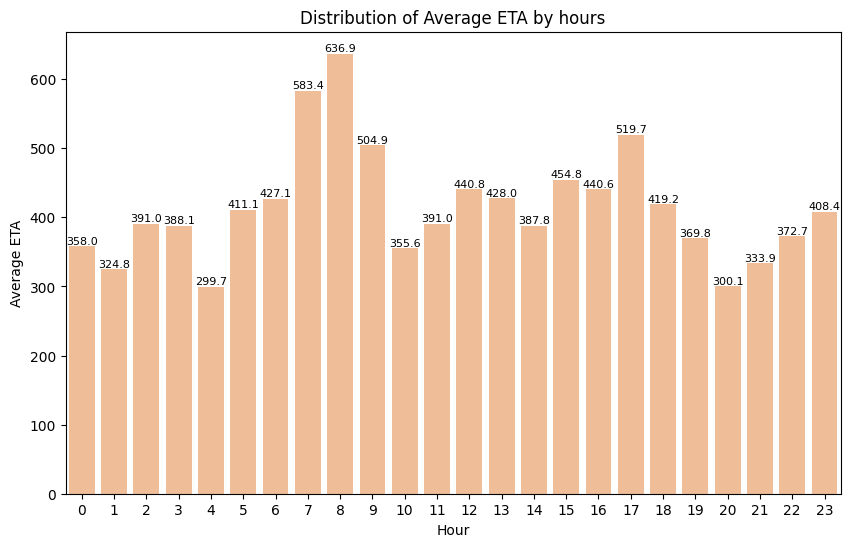

In [11]:
# Calculate the average ETA by hour
average_eta_by_hour = data_orders.groupby('hour', as_index=False)['m_order_eta'].mean()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='hour', y='m_order_eta', data=average_eta_by_hour, color='#FEAB6D', alpha=0.8,linewidth=2)

for i, p in enumerate(ax.patches):  
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%.1f' % p.get_height(),
            ha='center', va='bottom', fontsize=8)

plt.title('Distribution of Average ETA by hours')
plt.xlabel('Hour')
plt.ylabel('Average ETA')
plt.show()

# Task5: BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [12]:
# pip install h3 folium

In [14]:
import h3
import folium

resolution = 8
# Convert latitude and longitude to H3 hexagons
data_orders['h3_hex_id'] = data_orders.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], resolution), axis=1)
# Calculate counts of orders per hexagon
hex_counts = data_orders['h3_hex_id'].value_counts()
cumulative_counts = hex_counts.cumsum()
# cumulative_counts
total_orders=hex_counts.sum()
# 10716
total_orders
# Calculate the hexagons containing 80% of all orders
hexagons_80_percent = cumulative_counts[cumulative_counts <= total_orders * 0.8]
hex_counts_80_percent = hex_counts.loc[hexagons_80_percent.index]
# print(hex_counts_80_percent)

# Create a map centered at the mean latitude and longitude of orders
mean_latitude = data_orders['origin_latitude'].mean()
mean_longitude = data_orders['origin_longitude'].mean()
m = folium.Map(location=[mean_latitude, mean_longitude])

color_scale = folium.LinearColormap(['#ff9f0a','#ff4f00','#ff0000','#f600ff','#6300ff'], vmin=hex_counts_80_percent.min(), vmax=hex_counts_80_percent.max())
# Add hexagons to the map
for hex_id, count in hex_counts_80_percent.items():
#     print(count)
    polygon = h3.h3_to_geo_boundary(hex_id)
    fill_color = color_scale(count)
    folium.Polygon(locations=polygon, fill=True, fill_color=fill_color, fill_opacity=0.5).add_to(m)
#     folium.RegularPolygonMarker(location=[lat, lng], fill_color=fill_color, number_of_sides=6, radius=15,fill_opacity = 0.4).add_to(m)

# Add color scale to the map
color_scale.add_to(m)
m.save('Map.html')
m